In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
# Mod_count_data is data pulled from MySQL dump
mod_count_data = pd.read_csv("mod_data.txt", delimiter = "\t")
mod_count_data['timestamp'] = pd.to_datetime(mod_count_data['timestamp'], errors='coerce')

# Sorting data from alphabetical and earliest time stamp to latest
sorted_mod_data = mod_count_data.sort_values(by=['subreddit', 'timestamp'])
sorted_mod_data["time_diff"] = sorted_mod_data.groupby(['subreddit'])["timestamp"].diff()
sorted_mod_data["mod_diff"] = sorted_mod_data.groupby(['subreddit'])["num_mods"].diff()
sorted_mod_data["mod_diff"] = sorted_mod_data["mod_diff"].fillna(0)
sorted_mod_data = sorted_mod_data.reset_index()

In [4]:
# Function that creates the mods_gained and mods_lost columns. Looks at json mod data and compares unique names from
# two different timestamps on a subreddit. The first instance of a subreddit will results in 0 mods_gained and 0 mods_lost. 
def mod_churn(df):
    # unpacks mods_json column
    new_df = df.join(df['mods_json'].apply(json.loads).apply(pd.Series))
    data = new_df['data']
    
    # creating sets to compare names with
    set1 = set()
    set2 = set()
    
    # gained and lost arrays will be returned and turned into columns
    gained = []
    lost = []

    # to keep track of what subreddit we are on using a simple enumerate to check which subreddit we are on
    i = 0
    subreddit = new_df['subreddit']
    
    for x in data:
        # first row of dataframe can't compare to -1 row so had to make this an if statement
        if(i == 0):
            gained.append(0)
            lost.append(0)
            for y in x['children']:
                name = y['name']
                set2.add(name)
        # this else if is when we are actually checking to see if the same subreddit has seen any churn via gained/lost
        elif(new_df['subreddit'][i] == new_df['subreddit'][i - 1]):
            set2 = set()
            for y in x['children']:
                name = y['name']
                set2.add(name)
            if(len(set1) == 0):
                gained.append(0)
                lost.append(0)
            else:
                diff = 0
                for name in set1:
                    if(name not in set2):
                        diff += 1
                lost.append(diff)
                diff = 0
                for name in set2:
                    if(name not in set1):
                        diff += 1
                gained.append(diff)
        # this case is when the subreddits don't match so we want to set the first instance of a subreddit to 0, 0
        else:
            set2 = set()
            gained.append(0)
            lost.append(0)
        set1 = set2.copy()
        i += 1
    return gained, lost   

In [5]:
new_df = sorted_mod_data.join(sorted_mod_data['mods_json'].apply(json.loads).apply(pd.Series))
new_df

,index,subreddit,timestamp,mods_json,num_mods,time_diff,mod_diff,kind,data
0,80,4chanmeta,2020-10-03 03:00:22,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",15,NaT,0.0,UserList,"{'children': [{'name': 'Deathwave88', 'author_..."
1,284,4chanmeta,2020-11-15 23:14:32,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,43 days 20:14:10,-1.0,UserList,"{'children': [{'name': 'Deathwave88', 'author_..."
2,533,4chanmeta,2020-11-27 03:28:12,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,11 days 04:13:40,0.0,UserList,"{'children': [{'name': 'Deathwave88', 'author_..."
3,738,4chanmeta,2020-12-31 01:15:31,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,33 days 21:47:19,0.0,UserList,"{'children': [{'name': 'Deathwave88', 'author_..."
4,943,4chanmeta,2021-01-22 18:45:19,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,22 days 17:29:48,0.0,UserList,"{'children': [{'name': 'Deathwave88', 'author_..."
...,...,...,...,...,...,...,...,...,...
3404,2514,youtubecomments,2021-12-09 06:41:32,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",12,24 days 00:10:54,0.0,UserList,"{'children': [{'name': 'david12scht', 'author_..."
3405,2718,youtubecomments,2022-01-08 12:05:42,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",11,30 days 05:24:10,-1.0,UserList,"{'children': [{'name': 'david12scht', 'author_..."
3406,2922,youtubecomments,2022-02-09 17:01:58,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",11,32 days 04:56:16,0.0,UserList,"{'children': [{'name': 'david12scht', 'author_..."
3407,3125,youtubecomments,2022-03-14 14:43:57,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",11,32 days 21:41:59,0.0,UserList,"{'children': [{'name': 'david12scht', 'author_..."


In [6]:
mods_gained, mods_lost = mod_churn(sorted_mod_data)
sorted_mod_data['mods_gained'] = mods_gained
sorted_mod_data['mods_lost'] = mods_lost
sorted_mod_data.tail(20)

,index,subreddit,timestamp,mods_json,num_mods,time_diff,mod_diff,mods_gained,mods_lost
3389,2883,words,2022-02-08 07:25:31,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",2,31 days 02:25:03,0.0,0,0
3390,3086,words,2022-03-14 07:23:19,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",2,33 days 23:57:48,0.0,0,0
3391,3290,words,2022-04-11 04:30:26,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",2,27 days 21:07:07,0.0,0,0
3392,139,youtubecomments,2020-10-04 15:01:49,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,NaT,0.0,0,0
3393,344,youtubecomments,2020-11-16 14:29:40,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,42 days 23:27:51,0.0,0,0
3394,473,youtubecomments,2020-11-26 07:49:15,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,9 days 17:19:35,0.0,0,0
3395,678,youtubecomments,2020-12-30 05:51:15,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,33 days 22:02:00,0.0,0,0
3396,883,youtubecomments,2021-01-21 23:23:24,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,22 days 17:32:09,0.0,0,0
3397,1087,youtubecomments,2021-02-21 00:30:48,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,30 days 01:07:24,0.0,0,0
3398,1291,youtubecomments,2021-04-13 22:56:37,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,51 days 22:25:49,0.0,0,0


In [7]:
total_df = sorted_mod_data.groupby(['subreddit']).sum().reset_index()
print(total_df)

                 subreddit  index  num_mods  mod_diff  mods_gained  mods_lost
0                4chanmeta  29795       247      -1.0            1          2
1               7daystodie  29885       165      -1.0            1          2
2                 90smusic  29287       162       0.0            1          1
3                 absolver  27017        48       0.0            0          0
4                aerospace  28403        51       0.0            0          0
..                     ...    ...       ...       ...          ...        ...
201  wholesomestarterpacks  27245       112       0.0            0          0
202               winnipeg  28624       203      -2.0            0          2
203               witcher3  29911        67      -2.0            1          3
204                  words  28507        34       0.0            0          0
205        youtubecomments  29014       218      -3.0            0          3

[206 rows x 6 columns]


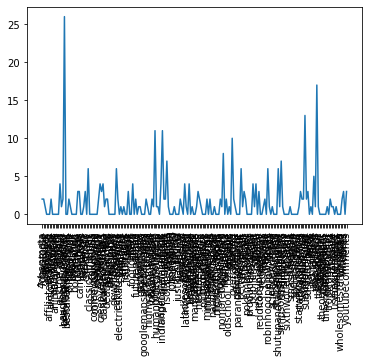

In [8]:
plt.plot(total_df['subreddit'], total_df['mods_lost'], '-')
plt.xticks(rotation = 90)
plt.show()

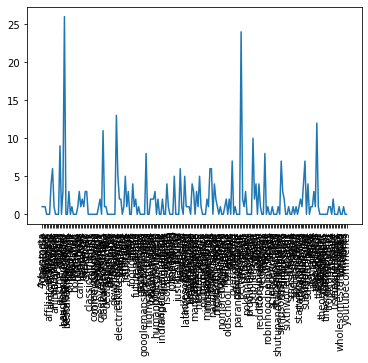

In [9]:
plt.plot(total_df['subreddit'], total_df['mods_gained'], '-')
plt.xticks(rotation = 90)
plt.show()

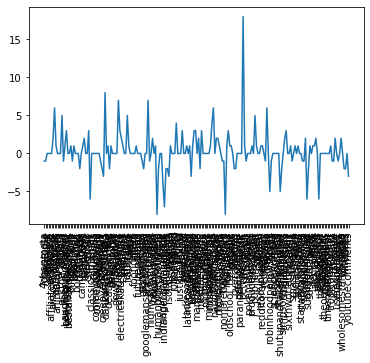

In [10]:
plt.plot(total_df['subreddit'], total_df['mod_diff'], '-')
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:xlabel='mod_diff', ylabel='mods_gained'>

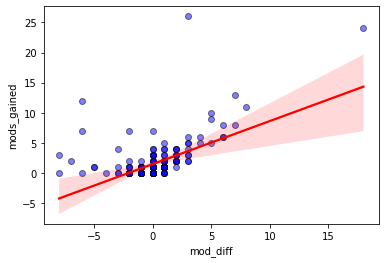

In [11]:
sns.regplot(y = "mods_gained", x = "mod_diff",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=total_df)

<AxesSubplot:xlabel='mod_diff', ylabel='mods_lost'>

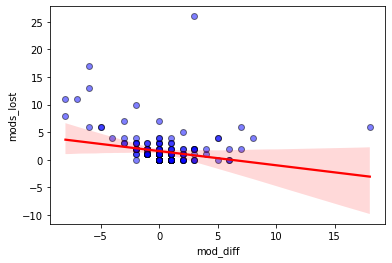

In [12]:
sns.regplot(y = "mods_lost", x = "mod_diff",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=total_df)

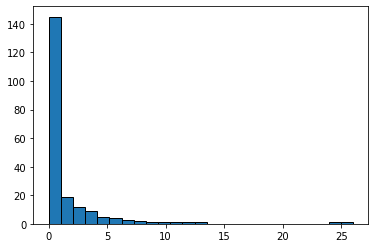

In [13]:
plt.hist(total_df['mods_gained'], edgecolor = 'black', bins = 25)
plt.show()

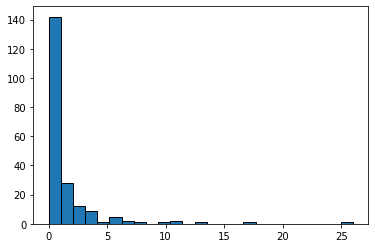

In [14]:
plt.hist(total_df['mods_lost'], edgecolor = 'black', bins = 25)
plt.show()

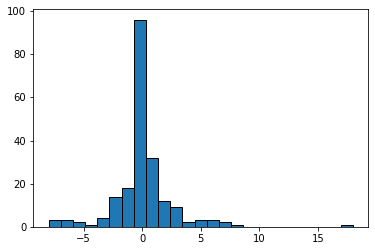

In [15]:
plt.hist(total_df['mod_diff'], edgecolor = 'black', bins = 25)
plt.show()

In [16]:
mean_df = sorted_mod_data.groupby('subreddit').mean().reset_index()
print(mean_df)

                 subreddit        index   num_mods  mod_diff  mods_gained  \
0                4chanmeta  1752.647059  14.529412 -0.058824     0.058824   
1               7daystodie  1757.941176   9.705882 -0.058824     0.058824   
2                 90smusic  1722.764706   9.529412  0.000000     0.058824   
3                 absolver  1688.562500   3.000000  0.000000     0.000000   
4                aerospace  1670.764706   3.000000  0.000000     0.000000   
..                     ...          ...        ...       ...          ...   
201  wholesomestarterpacks  1702.812500   7.000000  0.000000     0.000000   
202               winnipeg  1683.764706  11.941176 -0.117647     0.000000   
203               witcher3  1759.470588   3.941176 -0.117647     0.058824   
204                  words  1676.882353   2.000000  0.000000     0.000000   
205        youtubecomments  1706.705882  12.823529 -0.176471     0.000000   

     mods_lost  
0     0.117647  
1     0.117647  
2     0.058824  
3     0

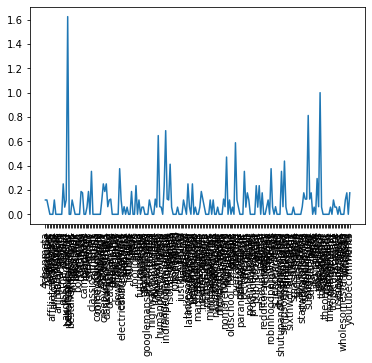

In [17]:
plt.plot(mean_df['subreddit'], mean_df['mods_lost'], '-')
plt.xticks(rotation = 90)
plt.show()

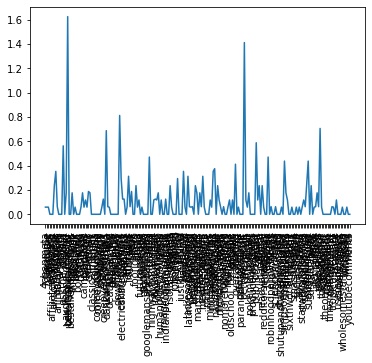

In [18]:
plt.plot(mean_df['subreddit'], mean_df['mods_gained'], '-')
plt.xticks(rotation = 90)
plt.show()

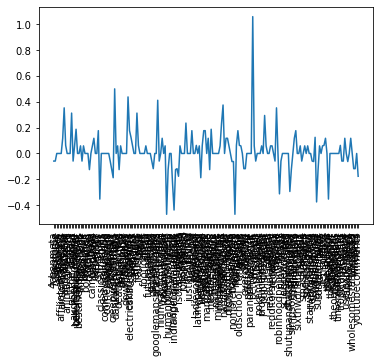

In [19]:
plt.plot(mean_df['subreddit'], mean_df['mod_diff'], '-')
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:xlabel='mod_diff', ylabel='mods_gained'>

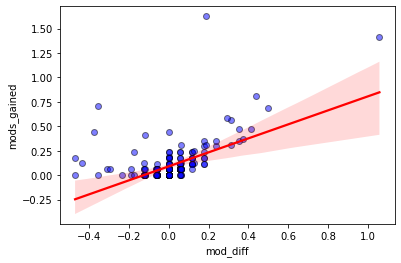

In [20]:
sns.regplot(y = "mods_gained", x = "mod_diff",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=mean_df)

<AxesSubplot:xlabel='mod_diff', ylabel='mods_lost'>

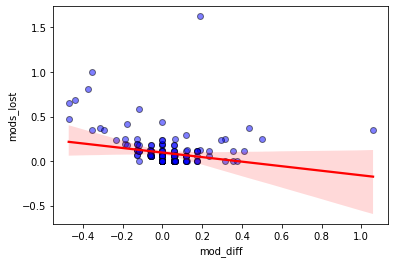

In [21]:
sns.regplot(y = "mods_lost", x = "mod_diff",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=mean_df)